In [1]:
import tensorflow as tf
tf.version.VERSION

'2.8.0'

In [2]:
# set Keras backend to Tensorflow
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [3]:
# import
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np

In [4]:
# make saving directory
saveDir = "./cifar10/semiTest10/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [5]:
# get Cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x train shape:', x_train.shape)
print(x_train.shape[0], 'training images')
print(x_test.shape[0], 'test images')

x train shape: (50000, 32, 32, 3)
50000 training images
10000 test images


In [6]:
from keras.utils import np_utils
# prerequisite
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
initNum = 10000
x_train1 = x_train[:initNum]
y_train1 = y_train[:initNum]
remainXTrain = x_train[initNum:]
remainYTrain = y_train[initNum:]

In [8]:
print("initial training X: {0}\n\
initial training Y: {1}\n\
remaining training X: {2}\n\
remaining training Y: {3}\n\
test X: {4}\n\
test Y: {5}".format(
    x_train1.shape,y_train1.shape,remainXTrain.shape,remainYTrain.shape,x_test.shape,y_test.shape))

initial training X: (10000, 32, 32, 3)
initial training Y: (10000, 10)
remaining training X: (40000, 32, 32, 3)
remaining training Y: (40000, 10)
test X: (10000, 32, 32, 3)
test Y: (10000, 10)


In [9]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [10]:
from tensorflow.keras.optimizers import Adam

# optimization and compile
def compileModel(model, lr=0.001, decay=1e-6):
    opt = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [11]:
# define layers
def getModel(loadModel=False, modelFilePath="", lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model = compileModel(model)
    
    # load model weights if specified
    if loadModel == True:
        model.load_weights(modelFilePath)
    
    return model

In [12]:
# get the newest model file
def getNewestModel(dirname=saveDir):
    import os
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return getModel()
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        return getModel(True, newestModel[0])

In [13]:
# get the CNN model
model = getModel()

In [14]:
# train the model
def trainModel(model, xTrain, yTrain, xTest, yTest, batch_size=50, epochs=100, patience=1):
    es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train
    model.fit(xTrain, yTrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xTest, yTest),
              callbacks=[es_cb, cp_cb],
              shuffle=True)
    return model

In [15]:
# run training on the initial dataset

model = trainModel(model, x_train1, y_train1, x_test, y_test, patience=2)


Epoch 1: val_loss improved from inf to 1.59421, saving model to ./cifar10/semiTest10\Cifar10_.01-1.90-1.59.hdf5

Epoch 2: val_loss improved from 1.59421 to 1.50386, saving model to ./cifar10/semiTest10\Cifar10_.02-1.52-1.50.hdf5

Epoch 3: val_loss improved from 1.50386 to 1.29892, saving model to ./cifar10/semiTest10\Cifar10_.03-1.35-1.30.hdf5

Epoch 4: val_loss improved from 1.29892 to 1.24291, saving model to ./cifar10/semiTest10\Cifar10_.04-1.23-1.24.hdf5

Epoch 5: val_loss improved from 1.24291 to 1.12027, saving model to ./cifar10/semiTest10\Cifar10_.05-1.12-1.12.hdf5

Epoch 6: val_loss improved from 1.12027 to 1.11982, saving model to ./cifar10/semiTest10\Cifar10_.06-1.03-1.12.hdf5

Epoch 7: val_loss improved from 1.11982 to 1.06558, saving model to ./cifar10/semiTest10\Cifar10_.07-0.93-1.07.hdf5

Epoch 8: val_loss improved from 1.06558 to 1.01478, saving model to ./cifar10/semiTest10\Cifar10_.08-0.85-1.01.hdf5

Epoch 9: val_loss did not improve from 1.01478

Epoch 10: val_loss 

In [16]:
# use the pre-trained model, with 65% accuracy on test data
# model = getNewestModel()
model.load_weights("./cifar10/semiTest10/Cifar10_.08-0.85-1.01.hdf5")

In [17]:
# define evaluation method
def evaluate(model, xTest, yTest, display=False):
    # only shows loss and accuracy
    if display == False:
        ev = model.evaluate(xTest, yTest, verbose=0)
        return ev
    # shows confusion matrix, classification report and accuracy score
    else:
        import pandas as pd
        import seaborn as sn
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report, accuracy_score

        def toNum(y):
            yNum = []
            for x in y:
                yNum.append(x.argmax())
            return np.array(yNum)

        # visualize confusion matrix on heat map
        def print_cmx(y_true, y_pred):
            labels = sorted(list(set(y_true)))
            cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

            df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

            plt.figure(figsize = (10,7))
            sn.heatmap(df_cmx, annot=True)
            plt.show()

        # reshape testing target to fit to scikit-learn metric form
        y_testPred = model.predict(xTest)
        y_testP = toNum(y_testPred)
        y_true = toNum(yTest)

        # get confusion matrix, classification report and accuracy score
        print_cmx(y_true, y_testP)
        print(classification_report(y_true, y_testP))
        print("Accuracy: {0}".format(accuracy_score(y_true, y_testP)))

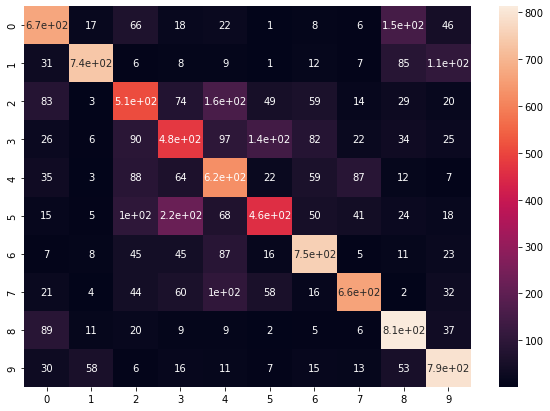

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1000
           1       0.86      0.73      0.79      1000
           2       0.52      0.51      0.52      1000
           3       0.48      0.48      0.48      1000
           4       0.52      0.62      0.57      1000
           5       0.61      0.46      0.52      1000
           6       0.71      0.75      0.73      1000
           7       0.77      0.66      0.71      1000
           8       0.67      0.81      0.74      1000
           9       0.72      0.79      0.75      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

Accuracy: 0.6487


In [18]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [19]:
# record the loss and accuracy
evalHistory = []
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])


[1.0147773027420044, 0.6486999988555908]


In [20]:
# get a list of high probability inference
def getHighProb(proba, bound):
    ls = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                ls.append([i,p])
    return ls

In [21]:
# concatenate initial training data with high probability inference, removing them from remaining data

from keras import utils as np_utils


def concatHighProbData(proba, remainX, remainY, xTrain, yTrain, bound=0.99):
    hp = getHighProb(proba, bound)
    print("number of data with probability higher than {0}: {1}".format(bound,len(hp)))
    
    nhp = np.array(hp)
    xAdd = remainX[nhp[:,0]]
    yAdd = np.array([nhp[:,1]]).T
    yAdd = keras.utils.np_utils.to_categorical(yAdd, num_classes)
    yActual = remainY[nhp[:,0]]
    print("x shape to be added: {0}\ny shape to be added: {1}".format(xAdd.shape, yAdd.shape))
    
    NewXTrain = np.vstack((xTrain, xAdd))
    NewYTrain = np.vstack((yTrain, yAdd))
    print("new training data:\n\tx: {0}\n\ty: {1}".format(NewXTrain.shape, NewYTrain.shape))
    
    remainX2 = np.delete(remainX, nhp[:,0], axis=0)
    remainY2 = np.delete(remainY, nhp[:,0], axis=0)
    print("remaining data:\n\tx: {0}\n\ty: {1}".format(remainX2.shape, remainY2.shape))
    
    yEval = [[yActual[i],yAdd[i]] for i in range(len(yAdd))]
    
    return remainX2, remainY2, NewXTrain, NewYTrain, yEval

In [22]:
def getError(yEval):
    errLabel = [0]*10
    for i in range(len(yEval)):
        if False in (yEval[i][0] == yEval[i][1]):
            errLabel[np.argmax(yEval[i][0]-yEval[i][1])] += 1
    return errLabel

In [23]:
# get new training data
# proba = model.predict_proba(remainXTrain, verbose=0)
proba=model.predict(remainXTrain,verbose=0)
remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatHighProbData(proba, 
                                                                          remainXTrain, 
                                                                          remainYTrain, 
                                                                          x_train1, 
                                                                          y_train1, 
                                                                          0.9999)
errPred = getError(yEval)

number of data with probability higher than 0.9999: 139
x shape to be added: (139, 32, 32, 3)
y shape to be added: (139, 10)
new training data:
	x: (10139, 32, 32, 3)
	y: (10139, 10)
remaining data:
	x: (39861, 32, 32, 3)
	y: (39861, 10)


In [24]:
# retrain the model
model = trainModel(model, x_train2, y_train2, x_test, y_test)


Epoch 1: val_loss improved from inf to 0.98556, saving model to ./cifar10/semiTest10\Cifar10_.01-0.74-0.99.hdf5

Epoch 2: val_loss did not improve from 0.98556
Epoch 2: early stopping


In [25]:
# load the newest checkpoint model to get the best accuracy one
model = getNewestModel()

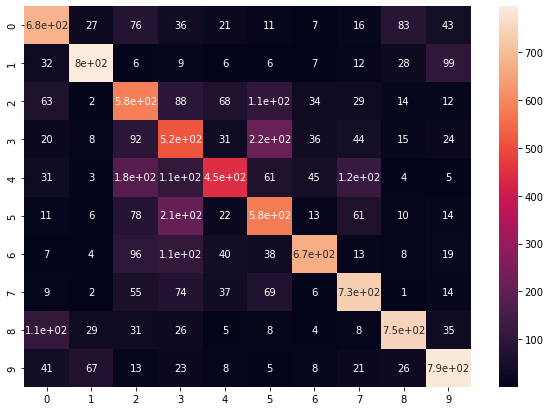

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1000
           1       0.84      0.80      0.82      1000
           2       0.48      0.58      0.53      1000
           3       0.43      0.52      0.47      1000
           4       0.65      0.45      0.53      1000
           5       0.53      0.58      0.55      1000
           6       0.81      0.67      0.73      1000
           7       0.69      0.73      0.71      1000
           8       0.80      0.75      0.77      1000
           9       0.75      0.79      0.77      1000

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.66     10000
weighted avg       0.67      0.65      0.66     10000

Accuracy: 0.6533


In [26]:
# evaluate with the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [27]:
# record the loss and accuracy
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[0.9855553507804871, 0.6532999873161316]


In [28]:
for i in range(10):
    #proba = model.predict_proba(remainXTrain, verbose=0)
    proba=model.predict(remainXTrain,verbose=0)
    remainXTrain, remainYTrain, x_train2, y_train2, yEval = concatHighProbData(proba, 
                                                                               remainXTrain, 
                                                                               remainYTrain, 
                                                                               x_train2, 
                                                                               y_train2, 
                                                                               0.9999)
    errPred2 = getError(yEval)
    errPred = [errPred2[i]+errPred[i] for i in range(len(errPred))]
    model = trainModel(model, x_train2, y_train2, x_test, y_test)
    model = getNewestModel()
    evalHistory.append(evaluate(model, x_test, y_test, display=False))
    print("\nAfter Iter: {0}\n\tLoss and Acc: {1}\n".format(i,evalHistory[-1]))

number of data with probability higher than 0.9999: 124
x shape to be added: (124, 32, 32, 3)
y shape to be added: (124, 10)
new training data:
	x: (10263, 32, 32, 3)
	y: (10263, 10)
remaining data:
	x: (39737, 32, 32, 3)
	y: (39737, 10)

Epoch 1: val_loss improved from inf to 0.98493, saving model to ./cifar10/semiTest10\Cifar10_.01-0.65-0.98.hdf5

Epoch 2: val_loss did not improve from 0.98493
Epoch 2: early stopping

After Iter: 0
	Loss and Acc: [0.9849334955215454, 0.6694999933242798]

number of data with probability higher than 0.9999: 615
x shape to be added: (615, 32, 32, 3)
y shape to be added: (615, 10)
new training data:
	x: (10878, 32, 32, 3)
	y: (10878, 10)
remaining data:
	x: (39122, 32, 32, 3)
	y: (39122, 10)

Epoch 1: val_loss improved from inf to 1.02473, saving model to ./cifar10/semiTest10\Cifar10_.01-0.58-1.02.hdf5

Epoch 2: val_loss did not improve from 1.02473
Epoch 2: early stopping

After Iter: 1
	Loss and Acc: [1.0247254371643066, 0.6640999913215637]

number of 

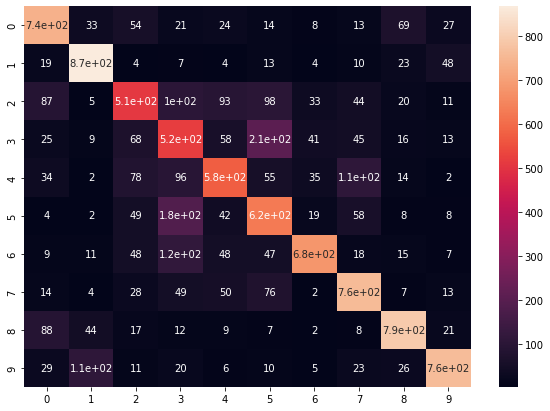

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1000
           1       0.80      0.87      0.83      1000
           2       0.59      0.51      0.54      1000
           3       0.46      0.52      0.49      1000
           4       0.63      0.58      0.60      1000
           5       0.54      0.62      0.58      1000
           6       0.82      0.68      0.74      1000
           7       0.70      0.76      0.73      1000
           8       0.80      0.79      0.80      1000
           9       0.84      0.76      0.80      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000

Accuracy: 0.6821


In [29]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [30]:
# show remaining data in each label
remainLabel = [0]*10
for y in remainYTrain:
    remainLabel[np.argmax(y)] += 1
remainLabel

[3490, 2015, 3863, 3955, 3945, 3922, 3267, 2899, 2943, 2951]

In [31]:
# show data in each label used on training
usedLabels = [5000-i for i in remainLabel]
usedLabels

[1510, 2985, 1137, 1045, 1055, 1078, 1733, 2101, 2057, 2049]

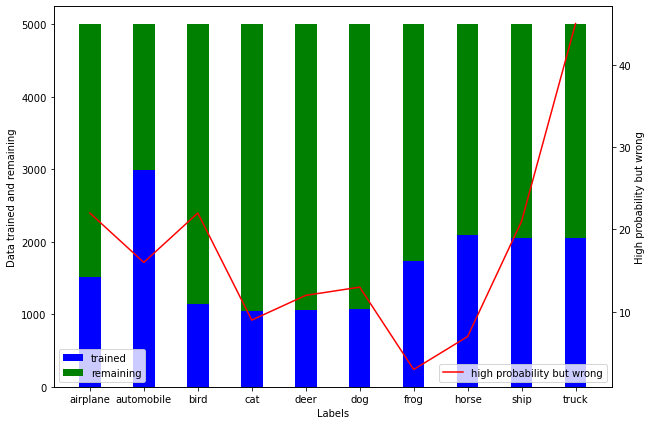

In [32]:
# show graph for the data used, remaining and number of errors with high probability prediction on each label
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize = (10,7))
ax2 = ax1.twinx()

w = 0.4
l1 = list(range(10))

ax1.bar(l1, usedLabels, align='center', color="blue", width=w, label='trained')
ax1.bar(l1, remainLabel, align='center', color="green", width=w, label='remaining', bottom=usedLabels)
ax2.plot(errPred,  color="red", label='high probability but wrong')
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")
ax1.set_xlabel("Labels")
ax1.set_ylabel("Data trained and remaining")
ax2.set_ylabel("High probability but wrong")

plt.xticks(l1, labels)
plt.show()

In [33]:
for i in range(10):
    print("{0}:\t{1}% wrong label added".format(labels[i], round((errPred[i]/usedLabels[i])*100, 3)))

airplane:	1.457% wrong label added
automobile:	0.536% wrong label added
bird:	1.935% wrong label added
cat:	0.861% wrong label added
deer:	1.137% wrong label added
dog:	1.206% wrong label added
frog:	0.173% wrong label added
horse:	0.333% wrong label added
ship:	1.021% wrong label added
truck:	2.196% wrong label added


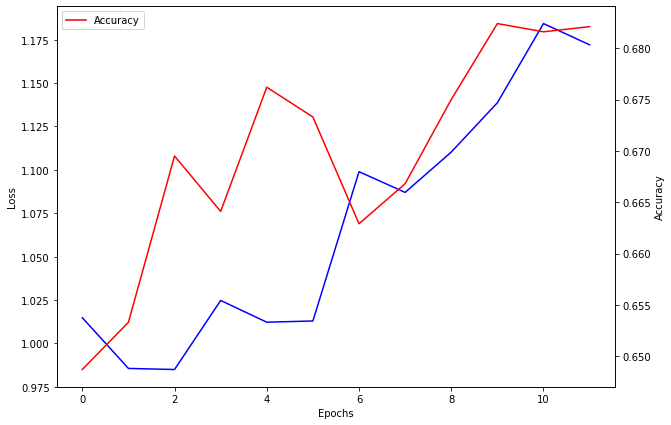

In [34]:
# show evaluation history
npeh = np.array(evalHistory)
fig, ax1 = plt.subplots(figsize=(10,7))
epochHis = list(range(12))
ax1.plot(epochHis, npeh[:,0], "b", label="Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(epochHis, npeh[:,1], "r", label="Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [35]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 150, 150
img = image.load_img('./animal10//1.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

print(img)

[[[[ 95.  62.  53.]
   [ 92.  58.  49.]
   [ 91.  57.  48.]
   ...
   [216. 199. 153.]
   [215. 198. 152.]
   [217. 200. 154.]]

  [[ 82.  49.  40.]
   [ 93.  59.  50.]
   [ 79.  45.  36.]
   ...
   [209. 192. 146.]
   [209. 192. 146.]
   [211. 194. 148.]]

  [[ 82.  49.  40.]
   [ 93.  59.  50.]
   [ 76.  42.  33.]
   ...
   [207. 190. 144.]
   [207. 190. 144.]
   [210. 193. 147.]]

  ...

  [[ 93.  64.  32.]
   [ 88.  66.  42.]
   [ 95.  74.  57.]
   ...
   [ 84.  63.  42.]
   [ 99.  77.  53.]
   [121.  97.  69.]]

  [[ 94.  65.  33.]
   [101.  79.  55.]
   [104.  83.  66.]
   ...
   [ 85.  64.  45.]
   [ 97.  75.  51.]
   [115.  91.  63.]]

  [[ 96.  69.  42.]
   [102.  76.  51.]
   [110.  85.  63.]
   ...
   [ 79.  61.  41.]
   [ 87.  69.  45.]
   [111.  94.  68.]]]]


In [36]:
loaded_model = tf.keras.models.load_model('./cifar10/semiTest10/Cifar10_.03-0.18-1.17.hdf5')
loaded_model.layers[0].input_shape 

(None, 32, 32, 3)

In [37]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 activation_66 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 30, 30, 64)        36928     
                                                                 
 activation_67 (Activation)  (None, 30, 30, 64)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 15, 15, 64)        0         
                                                     

Text(0.5, 1.0, 'cat')

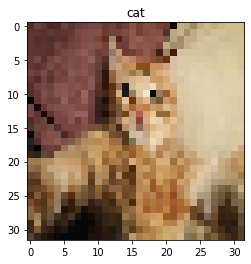

In [38]:
image_path="./animal10//1.png"
img = image.load_img(image_path, target_size=(32, 32))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
predict_x=model.predict(img)
result=np.argmax(predict_x,axis=1)
model.predict(img)

labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

model.predict(img)

plt.title(labels[int(result)])





Text(0.5, 1.0, 'horse')

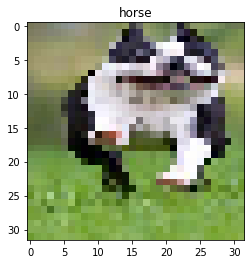

In [39]:
image_path="./animal10//OIP---cByAiEbIxIAleGo9AqOQAAAA.png"
img = image.load_img(image_path, target_size=(32, 32))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
predict_x=model.predict(img)
result=np.argmax(predict_x,axis=1)
model.predict(img)

labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

#model.predict(img)

plt.title(labels[int(result)])







Text(0.5, 1.0, 'horse')

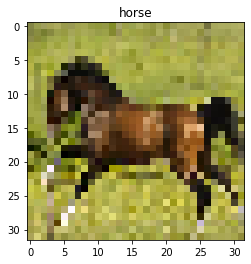

In [40]:
image_path="./animal10/horse/OIP---MGqQIhmz3OEPYP-46_xwHaFj.jpeg"
img = image.load_img(image_path, target_size=(32, 32))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
predict_x=model.predict(img)
result=np.argmax(predict_x,axis=1)
model.predict(img)

labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

#model.predict(img)

plt.title(labels[int(result)])


In [41]:
import os
batch_holder = np.zeros((20, 32, 32, 3))
img_dir='./animal10/test/'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(32,32))
  batch_holder[i, :] = img

In [42]:
#result=model.predict(batch_holder)

predict_x=model.predict(batch_holder)
result=np.argmax(predict_x,axis=1)

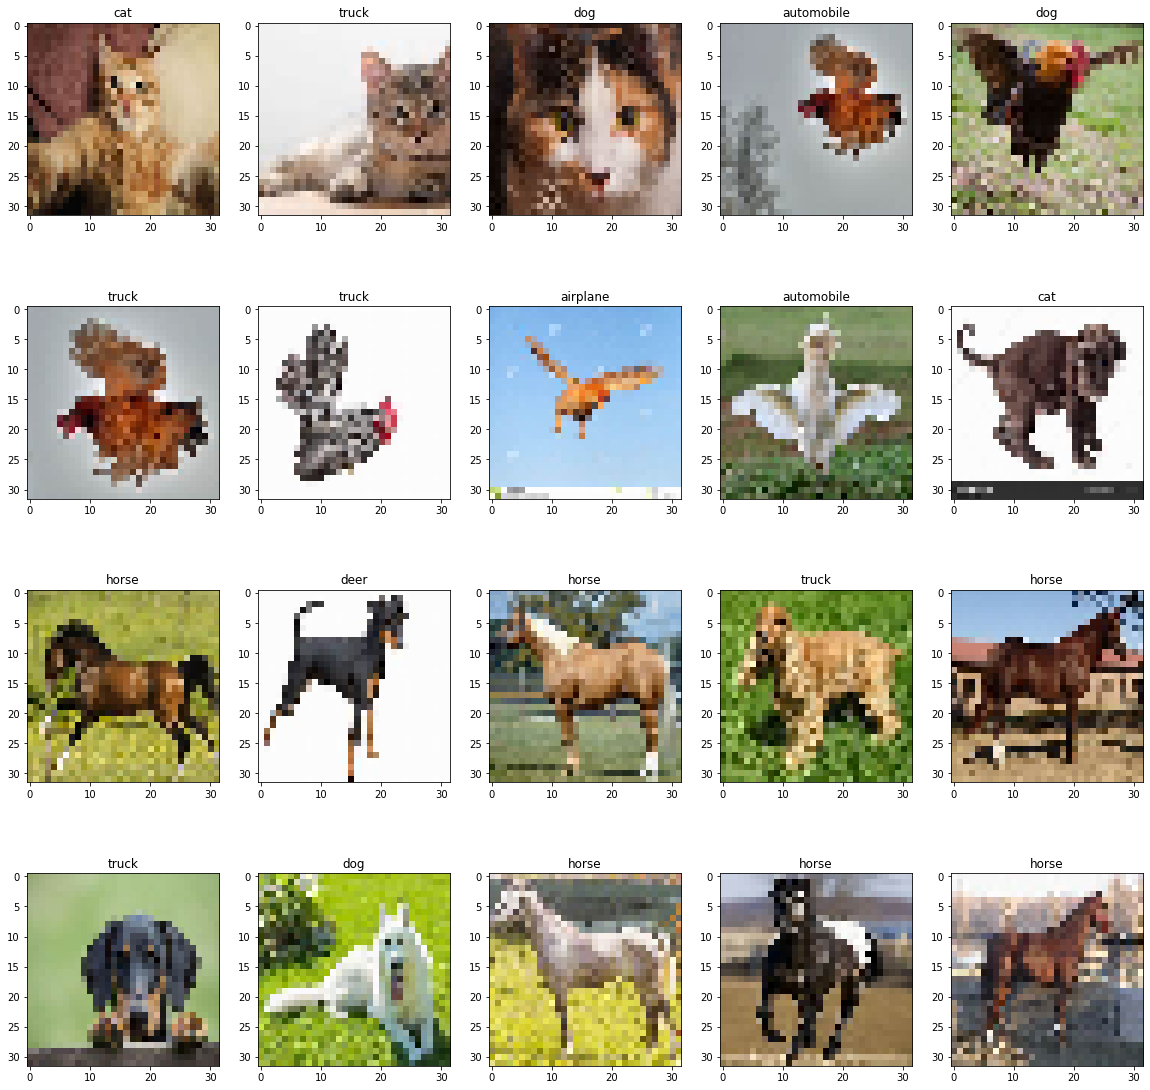

In [43]:
fig = plt.figure(figsize=(20, 20))

for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title(labels[int(result[i])]) 
  plt.imshow(img/256.)
plt.show()